## AERO3000 Space Systems Design

Faculty of Science and Engineering &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp; Space Science and Technology Centre &nbsp;&nbsp;|&nbsp;&nbsp; CRICOS Provider Code 00301J

# Mission Name Power Budget
Modelling the electrical generation, storage and consumption of our space system.

### Import Modules

In [ ]:
from astropy.time import Time #import astropy so we can use the astropy.Time class to set our epoch times
from astropy import units as u #import the astropy units package so we can use real world units conveniently
import numpy as np #import our maths library numpy under the alias np

### Calculate Your Power Generation Over Time
This code assumes you are generating at the begining of the modelled time period.

Update this code to model the power generation for your mission.

<mark>Not sure if we need this as the operational period is the lunar day -> constantly in the sun</mark>

In [ ]:
duration_in_min = 60*15
timestep_in_min = 5
t = np.arange(0, duration_in_min, timestep_in_min)*u.min
print(t)

generation_stop = 15*u.min
generation_restart = 110*u.min

illumination_status_list = [] #empty list

for i in range(len(t)):
    time = t[i]
    if ((generation_stop<=time) & (time<generation_restart)): #panels retracted or not tracking the Sun
        panels_illuminated = False
    else:
        panels_illuminated = True
    illumination_status_list.append(panels_illuminated)
    
in_sunlight_array = np.asarray(illumination_status_list)
print(in_sunlight_array)

### Plot Illumination Status Over Time

In [ ]:
# import plotly #import our graphing module plotly
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=t, y=in_sunlight_array)) #create a scatter plot from the in_eclipse_theta_array and in_eclipse_array
fig.layout.template = "plotly_dark" #activate the dark theme, comment out for light theme if you want

fig.update_yaxes(autorange="reversed") #flip y axis, comment out to unflip if required

fig.update_layout(title="Illumination Status Over Time (Simulated Period: {} min)".format(duration_in_min), #add figure title and axis titles
                  xaxis_title="t ({})".format(t.unit),
                  yaxis_title="In Sunlight",
                  )

fig.show() #display figure

### Enter Power Draws for Different Operational Modes

In [ ]:
p_idle = 60*u.W #idle
p_collecting = 360*u.W #using the arm to collect regolith
p_sintering = 750*u.W #heating up the regolith to sinter
p_cooling = 65*u.W #cooling down heated regolith
p_testing = 195*u.W #compressive test on brick and imaging

### Enter the Timing of the Different Modes

In [18]:
power_consumption = np.ones(t.shape)*u.W #array of p_data_processing, same shape as t
collecting_start = 5*u.min
collecting_duration = 30*u.min

sintering_start = 60*u.min
sintering_duration = 5*u.hour

cooling_start = 360*u.min
cooling_duration = 3*u.hour

testing_start = 560*u.min
testing_duration = 1*u.hour

### Calculate Consumption

In [19]:
for i in range(len(t)):
    time = t[i]
    if ((collecting_start<=time) & (time<collecting_start+collecting_duration)): #Collecting
        power_consumption[i] = p_collecting
    elif ((sintering_start<=time) & (time<sintering_start+sintering_duration)): #Sintering
        power_consumption[i] = p_sintering
    elif ((cooling_start<=time) & (time<cooling_start+cooling_duration)): #Cooling
        power_consumption[i] = p_cooling
    elif ((testing_start<=time) & (time<testing_start+testing_duration)): #comms contact
        power_consumption[i] = p_testing
    else:
        power_consumption[i] = p_idle

### Plot the Power Consumption Over the Relevant Time Period

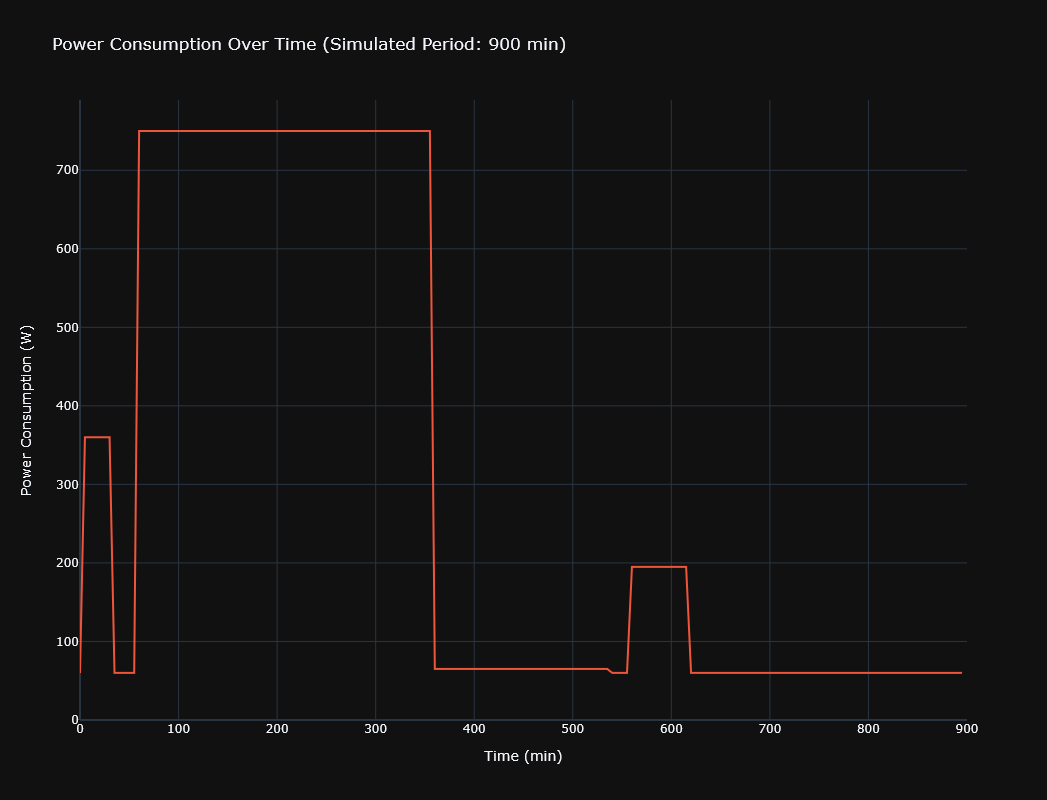

In [20]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=1)
fig.layout.template = 'plotly_dark' #activate the dark theme, comment out for light theme if you want

fig.add_trace(go.Scatter(x=t, y=power_consumption, name="Power Consumption ({})".format(power_consumption.unit), line=dict(color="#EF553B"), showlegend=False), row=1, col=1)

fig.update_yaxes(title_text="Power Consumption ({})".format(power_consumption.unit), rangemode="tozero", row=1, col=1)

fig.update_xaxes(range=[0, duration_in_min], row=1, col=1)
fig.update_xaxes(title_text="Time ({})".format(t.unit), range=[0, duration_in_min], row=1, col=1)

fig.update_layout(title_text="Power Consumption Over Time (Simulated Period: {} min)".format(duration_in_min),
                  height=800)

fig.show() #display figure

## Power Generation
(This is similar to section 10.6.3 in [chapter 10 "Electrical Power Systems" in Fortescue et al. (2011)](https://onlinelibrary-wiley-com.dbgw.lis.curtin.edu.au/doi/pdf/10.1002/9781119971009.ch10) on page 352.)

First: calculate your average power consumption:

In [21]:
p_avg = np.average(power_consumption)
print("Average power consumption: p_avg = {:.1f}".format(p_avg))

Average power consumption: p_avg = 310.0 W


To do the next step we will need to know the availability of the generation source (in sunlight fraction for solar power):

In [22]:
frac_gen_available = 1 #np.???(in_sunlight_array)
print("Availabity of generation : frac_gen_available = {:.0%}".format(frac_gen_available))

Availabity of generation : frac_gen_available = 100%


Then make an initial estimate of the required power generation by dividing by the availability of the generation source.

Keep in mind that this initial guess doesn't take into account different factors degrading the generation output such as temperature or radiation dose effects (damage) over time or inefficiencies in the system.

In [23]:
p_gen_initial_estimate = p_avg/frac_gen_available
print("Initial estimate of power generation capacity : p_gen_initial_estimate = {:.0f}".format(p_gen_initial_estimate))

Initial estimate of power generation capacity : p_gen_initial_estimate = 310 W


### Cell Selection
Select an [Azure Space](http://www.azurspace.com/index.php/en/) or [Rocket Lab SolAero](https://www.rocketlabusa.com/space-systems/solar/space-solar-cellscics/) **space** solar cell and calculate the **active** cell area required to deliver this power generation capcity.

Assume J_S = 1371 W/m$^2$ and that the panels remain normal to the Sun vector at all times.

Update the comment to include the cell assembly type and the link to the datasheet.

Print the result in centimetres squared.

In [24]:
# Update Solar radiaiton flux if not around 1 AU from the Sun
J_S = 1371*u.W/u.m**2 #solar radiation flux from Fortescue et al. (2011) page 359
eff_cell = 30.2/100 #<cell assembly type>, source: <cell assembly datasheet>

initial_estimate_cell_area = p_gen_initial_estimate/J_S/eff_cell
print("Initial estimate cell active area: initial_estimate_cell_area = {:.0f}".format(initial_estimate_cell_area.to(u.cm*u.cm)))

Initial estimate cell active area: initial_estimate_cell_area = 7487 cm2


Calculate the number of cell assemblies from the cell area if given in the datasheet. If not provided, you could assume cell area is 30.18 cm$^2$.

In [25]:
area_per_cell = 8*4*u.cm**2 #<cell assembly type>

#calculate number of cells, rounding up using the np.ceil() funciton
inital_estimate_n_cells =  np.ceil((initial_estimate_cell_area/area_per_cell).to(u.dimensionless_unscaled))

print("Initial estimate number of cells: inital_estimate_n_cells = {:.0f}".format(inital_estimate_n_cells))

Initial estimate number of cells: inital_estimate_n_cells = 234


### Calculate Losses

Assume battery charging is 90% efficient.

Assume degradation due to temperature rise is approximately 0.2 % per °C above room temperature (assumption is roughly based on [Rocket Lab SolAero ZTJ datasheet](https://www.rocketlabusa.com/assets/Uploads/RL-SolAero-Data-Sheet-ZTJ.pdf)). If you haven't done a thermal balance yet assume your cells are around 70 °C in an Earth orbit (although you should do a thermal balance calculation ASAP).

Assume a degradation due to radiation based on [Table 6.7 from Brown (2002) p. 339](https://ebookcentral.proquest.com/lib/curtin/reader.action?docID=3111499&ppg=352) and your mission parameters.

In [26]:
eff_charging = 90/100 #90% efficient solar tracking and cell charging
radiation_degradation_loss = 4/100 #<insert mission information>, based on Brown (2002) p. 339
temperature_loss = 17/100 #assumption rougly based on figure 6.18 on page 337 of Brown (2002)

### Determine Cell Area

Now pick your actual cell area or number of cells which should be informed by your initial estimates. (It should be larger, however.)

If you want, you can just pick you initial estimate for now, and then come back and refine it after the initial run of the model. An iterative approach like this is reasonable.

In [27]:
n_cells = 94
cell_area = n_cells * area_per_cell
print(cell_area.to(u.m**2))

0.3008 m2


### Calculate the Power Generation Over Time

Fill in the missing power generation capacity expression accounting for the losses below and then run the code.

Note that the expression for efficiencies will be different than the expression for losses.

In [28]:
# calculate your power generation capacity with losses
p_gen_capacity = (J_S*eff_cell*cell_area*(1-radiation_degradation_loss)*(1-temperature_loss)*eff_charging).to(u.W)
print("Power generation with losses: p_gen_capacity = {:.1f}".format(p_gen_capacity))

Power generation with losses: p_gen_capacity = 89.3 W


Now calculate your power generation over time array by multiplying the capacity (scalar) times the availability (array).

In [16]:
power_generation = p_gen_capacity*frac_gen_available

## Power Modelling of Nominal Operations
For now we are going to assume the batteries start empty and you have a very large battery capacity.

You should come back and improve these assumptions as you progress the design of your space system's electrical power system.

Fill in the missing expression to calculate the next energy storage level (it's a numerical integration of power over time) and then run the code below.

Also fill in the missing part of the expression to limit the maximum level of stored energy to the battery pack capacity.

In [17]:
e0 = 0*u.W*u.h # initial energy storage level
energy_storage_capacity = 1000*u.W*u.h #energy storage limit (battery pack capacity)

energy_stored = np.zeros(t.shape)*u.W*u.h #create array of zeroes the same shape as t

delta_t = t[1]-t[0]

for i in range(len(t)):
    time = t[i]
    if i==0:
        energy_stored[i] = e0
    else:
        next_energy_storage_level = energy_stored[i-1]+???
        if(next_energy_storage_level > ???):
            energy_stored[i] = energy_storage_capacity
        else:
            energy_stored[i] = next_energy_storage_level

from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1)

print("Energy stored after one orbit: {:.2f} WH".format(energy_stored[-1].to(u.W*u.h).value))
print("Minimum storage state: {:.2f} WH".format(energy_stored.min().to(u.W*u.h).value))
print("Maximum storage state: {:.2f} WH".format(energy_stored.max().to(u.W*u.h).value))


fig.layout.template = 'plotly_dark' #activate the dark theme, comment out for light theme if you want

fig.add_trace(go.Scatter(x=t, y=power_generation, name="Power Generation (W)", line=dict(color="#636EFA"), showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=t, y=power_consumption, name="Power Consumption (W)", line=dict(color="#EF553B"), showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=energy_stored, name="Energy Stored (WH)", line=dict(color="#00CC96"), showlegend=False), row=3, col=1)

fig.update_yaxes(title_text="Power Generation (W)", rangemode="tozero", row=1, col=1)
fig.update_yaxes(title_text="Power Consumption (W)", rangemode="tozero", row=2, col=1)
fig.update_yaxes(title_text="Energy Stored (WH)", rangemode="tozero", row=3, col=1)

fig.update_xaxes(range=[0, duration_in_min], row=1, col=1)
fig.update_xaxes(range=[0, duration_in_min], row=2, col=1)
fig.update_xaxes(title_text="Time ({})".format(t.unit), range=[0, duration_in_min], row=3, col=1)

fig.update_layout(title_text="Power Generation, Power Consumption and Energy Storage Over Time ({:.2f} min)".format(duration_in_min),
                  height=1000,
                  showlegend=True,
                  legend=dict(traceorder="normal"),
                  barmode="stack")

fig.show() #display figure

SyntaxError: invalid syntax (2163949252.py, line 13)

### Go Back and Select a Realistic Battery Pack Capacity and Initial Charge Level
Also check that you don't run out of power at any point. You may wish to move loads around (in time) if you have high power consumption when generation is not available.

Remember, you never what your space system to run out of power.

### Depth of Discharge
From the green trace above determine the depth of discharge and record it in the text box below as a percentage.

### Chose a Cell Chemistry
Write the chosen chemistry in the text box below.

### ~Projected Lifetime with Chosen Chemistry and Depth of Discharge~
~Update code for your chemistry and mission.~

This step doesn't make sense for missions without repetitive charge and discharge cycles (like a flyby or lander), so it probably doesn't apply.

Uncomment (Highlight, then press Ctrl + / ) and update the code below if it does apply to your mission.

In [ ]:
# # Number of charge-discharge cycles per orbit
# charge_cycles_per_orbit = 1
# #The cell chemsitry cycle life at the chosen depth of discharge
# cell_cycle_life_at_dod = 2000
# battery_pack_lifetime = (charge_cycles_per_orbit*cell_cycle_life_at_dod*tau).to(u.yr)
# print("Battery Pack Lifetime: {:.2}".format(battery_pack_lifetime))

# end_of_life_capacity_ratio = 0.6
# eol_remaining_capacity = (energy_storage_capacity*end_of_life_capacity_ratio).to(u.W*u.hr)
# print("Battery Pack Capacity Remaining at End of Life: {:.0f} WH".format(eol_remaining_capacity.value))

### Add in a Safety Factor and Print your Panel and Battery Pack Capacity

In [ ]:
#add your code here

### Battery Mass
Look up the energy density of your chosen chemistry, and calculate the approximate mass of your battery pack below. Feel free to rely on easily available sources for this, you don't necessarily need to use a high quality source for this step.

If you would like to look at some space battery cells, you can if you wish.

## Extension
Estimate the mass of your solar arrays. Account for the cells, the structure, and any interface layers or wiring if required.

Update your system's mass budget.

# References

[Brown, Charles D. 2002. *Elements of Spacecraft Design*. Reston, Virginia, USA: American Institute of Aeronautics and Astronautics.](https://ebookcentral.proquest.com/lib/curtin/detail.action?pq-origsite=primo&docID=3111499)

[Fortescue, Peter, Graham Swinerd, and John Stark, eds. 2011. *Spacecraft Systems Engineering*. Chichester, UK: John Wiley & Sons.](https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781119971009)